In [1]:
# Importing necessary libraries

# Building deep learning models
import tensorflow as tf 
from tensorflow import keras 
# For accessing pre-trained models
import tensorflow_hub as hub 
# For separating train and test sets
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL.Image as Image
import cv2

import os
import numpy as np
import pathlib

In [2]:
data_dir = "../input/rice-image-dataset/Rice_Image_Dataset" # Datasets path
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('../input/rice-image-dataset/Rice_Image_Dataset')

In [3]:
arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

In [4]:
# Contains the images path
df_images = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}

# Contains numerical labels for the categories
df_labels = {
    'arborio' : 0,
    'basmati' : 1,
    'ipsala' : 2,
    'jasmine' : 3,
    'karacadag': 4
}

In [5]:
img = cv2.imread(str(df_images['arborio'][0])) # Converting it into numerical arrays
img.shape # Its currently 250 by 250 by 3

(250, 250, 3)

In [6]:
X, y = [], [] # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on MobileNetv2 model
        X.append(resized_img) 
        y.append(df_labels[label])

In [7]:
# Standarizing
X = np.array(X)
X = X/255
y = np.array(y)

In [8]:
# Separating data into training, test and validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

In [9]:
mobile_net = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4' # MobileNetv4 link
mobile_net = hub.KerasLayer(
        mobile_net, input_shape=(224,224, 3), trainable=False) # Removing the last layer

In [10]:
num_label = 5 # number of labels

model = keras.Sequential([
    mobile_net,
    keras.layers.Dense(num_label)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [12]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
71/71 [==============================] - 14s 54ms/step - loss: 0.6069 - acc: 0.8169 - val_loss: 0.2043 - val_acc: 0.9681
Epoch 2/10
71/71 [==============================] - 2s 33ms/step - loss: 0.1681 - acc: 0.9662 - val_loss: 0.1243 - val_acc: 0.9894
Epoch 3/10
71/71 [==============================] - 2s 33ms/step - loss: 0.1189 - acc: 0.9711 - val_loss: 0.0939 - val_acc: 0.9840
Epoch 4/10
71/71 [==============================] - 2s 32ms/step - loss: 0.0914 - acc: 0.9800 - val_loss: 0.0785 - val_acc: 0.9894
Epoch 5/10
71/71 [==============================] - 2s 32ms/step - loss: 0.0772 - acc: 0.9840 - val_loss: 0.0677 - val_acc: 0.9894
Epoch 6/10
71/71 [==============================] - 2s 32ms/step - loss: 0.0658 - acc: 0.9853 - val_loss: 0.0569 - val_acc: 0.9947
Epoch 7/10
71/71 [==============================] - 3s 36ms/step - loss: 0.0581 - acc: 0.9880 - val_loss: 0.0545 - val_acc: 0.9894
Epoch 8/10
71/71 [==============================] - 2s 32ms/step - loss: 0.0507 - 

In [13]:
model.evaluate(X_test,y_test)

18/18 [==============================] - 1s 36ms/step - loss: 0.0650 - acc: 0.9733


[0.06500142812728882, 0.9733096361160278]

In [14]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

9/9 [==============================] - 1s 63ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       123
           1       0.98      0.97      0.98       109
           2       1.00      1.00      1.00       108
           3       0.93      0.97      0.95       112
           4       0.98      0.98      0.98       110

    accuracy                           0.97       562
   macro avg       0.97      0.97      0.97       562
weighted avg       0.97      0.97      0.97       562



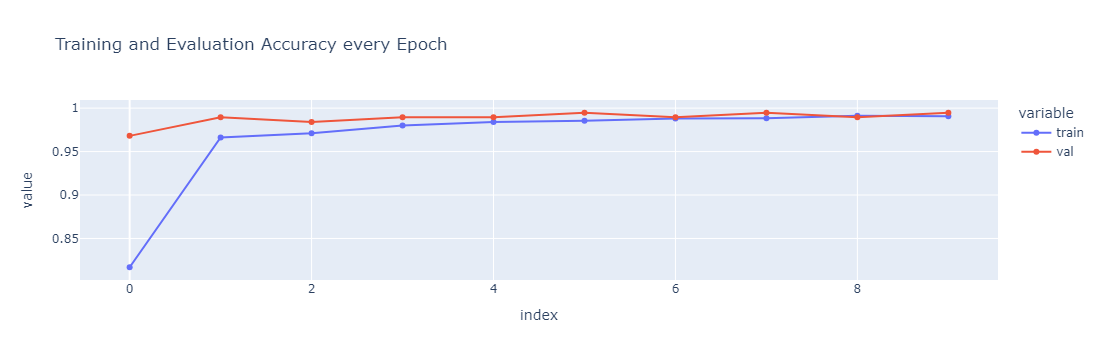

In [15]:
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas as pd

init_notebook_mode(connected=True)

acc = pd.DataFrame({'train': history.history['acc'], 'val': history.history['val_acc']})

fig = px.line(acc, x=acc.index, y=acc.columns[0::], title='Training and Evaluation Accuracy every Epoch', markers=True)
fig.show()

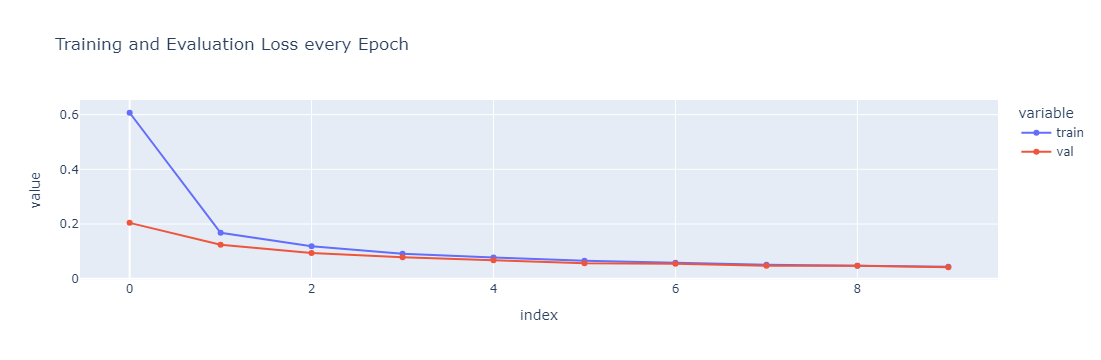

In [16]:
loss = pd.DataFrame({'train': history.history['loss'], 'val': history.history['val_loss']})

fig = px.line(loss, x=loss.index, y=loss.columns[0::], title='Training and Evaluation Loss every Epoch', markers=True)
fig.show()

In [17]:
X_test[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [18]:
X_test.shape

(562, 224, 224, 3)

In [19]:
a1 = cv2.imread("../input/rice-image-dataset/Rice_Image_Dataset/Basmati/basmati (10).jpg")
a1 = cv2.resize(a1,(224,224))
a1 = np.array(a1)
a1 = a1/255
a1 = np.expand_dims(a1, 0)
pred = model.predict(a1)
pred = pred.argmax()
pred

1

In [20]:
for i, j in df_labels.items():
    if pred == j:
        print(i)

basmati


In [21]:
a2 = cv2.imread("../input/rice-image-dataset/Rice_Image_Dataset/Ipsala/Ipsala (10).jpg")
a2 = cv2.resize(a2,(224,224))
a2 = np.array(a2)
a2 = a2/255
a2 = np.expand_dims(a2, 0)
a2.shape

(1, 224, 224, 3)

In [23]:
model.save("rice.h5")